In [1]:
import numpy as np
import xgboost as xgb

from wvz_helpers import load_dataframes, load_dataframe, skims

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import os

from sklearn.pipeline import Pipeline

test_size = 0.33
random_state = 42

In [2]:
from train_bdt import zz_features, ttz_features
features = ttz_features
#features = list(set(zz_features).union(set(ttz_features)))

In [3]:
features

['looper_MllN',
 'looper_ZPt',
 'looper_mt2',
 'looper_lep3Pt',
 'looper_lep4Pt',
 'looper_vecsum_pt_4l',
 'looper_scalarsum_pt_4l',
 'looper_minDRJetToLep3',
 'looper_minDRJetToLep4',
 'looper_jet1Pt']

In [247]:
xgb_params = dict(
    max_depth=3,
    learning_rate=0.1,
    #n_estimators=400,
    n_estimators=1000,
    reg_lambda=1.0,
    #objective="binary:logitraw",
)

In [218]:
df = load_dataframes(["nonh_wwz", "zh_wwz", "ttz", "zz"], concat=True)

Map to get from sample lables to integer indices and back:

In [219]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder().fit(["nonh_wwz", "zh_wwz", "ttz", "zz"])
df["sample_index"] = label_encoder.transform(df["sample"])

In [220]:
label_encoder.transform(["nonh_wwz", "zh_wwz", "ttz", "zz"])

array([0, 2, 1, 3])

In [221]:
def index_to_label(i):
    return label_encoder.inverse_transform([i])[0]

In [222]:
def label_to_index(label):
    return label_encoder.transform([i])[0]

Let's just check how many events end up in the b-tag category relatively:

In [223]:
df.query("is_ChannelBTagEMu")["sample"].value_counts() / \
df.query("is_ChannelBTagEMu or is_ChannelEMu")["sample"].value_counts()

nonh_wwz    0.143961
ttz         0.933486
zh_wwz      0.146471
zz          0.110829
Name: sample, dtype: float64

Let's just take this region in the training for all 4 samples, for simplicity, even if it's only needed in ttZ to get the stats to an acceptable level.

In [224]:
df_train = df.query("evt % 3 != 0 and is_ChannelEMu")
df_test = df.query("evt % 3 == 0 and is_ChannelEMu")

In [225]:
df_train_withbtag = df.query("evt % 3 != 0 and (is_ChannelEMu or is_ChannelEMu)")
df_test_withbtag = df.query("evt % 3 == 0 and (is_ChannelEMu or is_ChannelEMu)")

In [226]:
df_train["sample"].value_counts()

nonh_wwz    245886
zh_wwz       56098
zz           18406
ttz           1715
Name: sample, dtype: int64

In [227]:
df_test["sample"].value_counts()

nonh_wwz    122738
zh_wwz       28281
zz            9257
ttz            843
Name: sample, dtype: int64

## Training the Multiclassifiers

In [256]:
def train_bdt(X_train, y_train, X_test, y_test, xgb_params):

    n_pos = np.sum(y_train)
    n_neg = len(y_train) - n_pos
    print("n_pos: " + str(n_pos))
    print("n_neg: " + str(n_neg))
    scale_pos_weight = 1.0 * n_neg / n_pos

    model = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        #verbosity=2,
        n_jobs=4,
        random_state=random_state,
        **xgb_params
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=15, eval_metric="auc")

    return model

In [248]:
def get_binary_data(df, sample_1, sample_2):
    if isinstance(sample_1, str):
        sample_1 = label_to_index(sample_1)
    if isinstance(sample_2, str):
        sample_2 = label_to_index(sample_2)
        
    df_binary = df.query(f"sample_index == {sample_1} or sample_index == {sample_2}")
    
    X = df_binary[features].values
    y = (df_binary["sample_index"] == sample_2) + 0
    
    return X, y

In [249]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [250]:
from sklearn.isotonic import IsotonicRegression

In [251]:
n_classes = 4

In [252]:
import scipy.optimize

In [253]:
import scipy.interpolate

In [254]:
def calibration_curve(y_true, preds):
        fpr, tpr, th = roc_curve(y_true, preds)
        th = th[::-1]
        th[-1] = 1.
        fpr = fpr[::-1]
        tpr = tpr[::-1]

        sums = (fpr + tpr)[1::] * np.diff(th)
        integral = np.cumsum(sums[::-1])[::-1]
        plt.plot(th[1:], (th*(fpr + tpr))[1:] + integral, label="BDT (test)")
        rhs = (tpr[1:] - integral)/(fpr+tpr+1e-6)[1:]
        
        rhs = np.clip(rhs, 0.0, 1.0)
        rhs[-1] = 1
        
        th = np.concatenate([[0.0], th[1:]])
        rhs = np.concatenate([[0.0], rhs])
        
        return th, rhs

Training model ttz vs nonh_wwz (neg. vs pos.)...
n_pos: 245886
n_neg: 1715
[0]	validation_0-auc:0.764057
Will train until validation_0-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.771231
[2]	validation_0-auc:0.771076
[3]	validation_0-auc:0.773198
[4]	validation_0-auc:0.779528
[5]	validation_0-auc:0.781322
[6]	validation_0-auc:0.78341
[7]	validation_0-auc:0.786565
[8]	validation_0-auc:0.787704
[9]	validation_0-auc:0.788067
[10]	validation_0-auc:0.789219
[11]	validation_0-auc:0.790221
[12]	validation_0-auc:0.791468
[13]	validation_0-auc:0.792469
[14]	validation_0-auc:0.792139
[15]	validation_0-auc:0.792384
[16]	validation_0-auc:0.79207
[17]	validation_0-auc:0.792077
[18]	validation_0-auc:0.792642
[19]	validation_0-auc:0.792962
[20]	validation_0-auc:0.793772
[21]	validation_0-auc:0.793981
[22]	validation_0-auc:0.794959
[23]	validation_0-auc:0.794657
[24]	validation_0-auc:0.795154
[25]	validation_0-auc:0.796012
[26]	validation_0-auc:0.796386
[27]	validation_0-auc:0.796302
[28]	

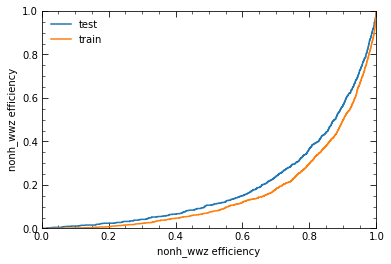

<ipython-input-257-a8a28425219d>:54: RuntimeWarning: invalid value encountered in true_divide
  l_ratio = h_pos/(h_pos+h_neg)


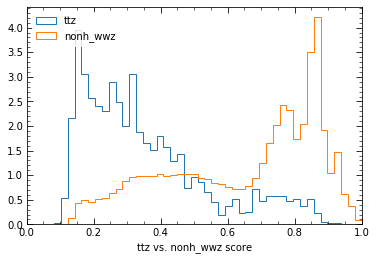

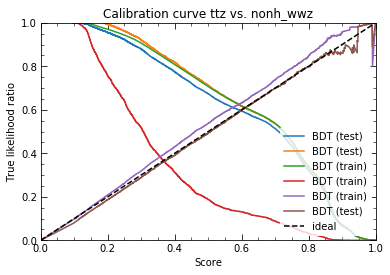

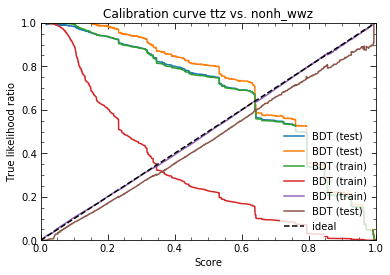

Training model zh_wwz vs nonh_wwz (neg. vs pos.)...
n_pos: 245886
n_neg: 56098
[0]	validation_0-auc:0.898998
Will train until validation_0-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.903702
[2]	validation_0-auc:0.905042
[3]	validation_0-auc:0.906027
[4]	validation_0-auc:0.907763
[5]	validation_0-auc:0.908158
[6]	validation_0-auc:0.908471
[7]	validation_0-auc:0.90889
[8]	validation_0-auc:0.910237
[9]	validation_0-auc:0.910534
[10]	validation_0-auc:0.911016
[11]	validation_0-auc:0.912741
[12]	validation_0-auc:0.913247
[13]	validation_0-auc:0.913132
[14]	validation_0-auc:0.914807
[15]	validation_0-auc:0.915228
[16]	validation_0-auc:0.915361
[17]	validation_0-auc:0.91619
[18]	validation_0-auc:0.916613
[19]	validation_0-auc:0.916972
[20]	validation_0-auc:0.917572
[21]	validation_0-auc:0.917844
[22]	validation_0-auc:0.918551
[23]	validation_0-auc:0.919093
[24]	validation_0-auc:0.919419
[25]	validation_0-auc:0.919741
[26]	validation_0-auc:0.920128
[27]	validation_0-auc:0.920333
[

[256]	validation_0-auc:0.929029
[257]	validation_0-auc:0.929029
[258]	validation_0-auc:0.929029
[259]	validation_0-auc:0.929032
[260]	validation_0-auc:0.929029
[261]	validation_0-auc:0.929027
[262]	validation_0-auc:0.929025
[263]	validation_0-auc:0.929038
[264]	validation_0-auc:0.929059
[265]	validation_0-auc:0.929064
[266]	validation_0-auc:0.929065
[267]	validation_0-auc:0.929066
[268]	validation_0-auc:0.929069
[269]	validation_0-auc:0.929091
[270]	validation_0-auc:0.929107
[271]	validation_0-auc:0.929107
[272]	validation_0-auc:0.929106
[273]	validation_0-auc:0.929123
[274]	validation_0-auc:0.929132
[275]	validation_0-auc:0.929148
[276]	validation_0-auc:0.929148
[277]	validation_0-auc:0.929148
[278]	validation_0-auc:0.92916
[279]	validation_0-auc:0.929163
[280]	validation_0-auc:0.929162
[281]	validation_0-auc:0.929172
[282]	validation_0-auc:0.929169
[283]	validation_0-auc:0.929176
[284]	validation_0-auc:0.929177
[285]	validation_0-auc:0.929203
[286]	validation_0-auc:0.929206
[287]	val

[513]	validation_0-auc:0.929878
[514]	validation_0-auc:0.92988
[515]	validation_0-auc:0.929877
[516]	validation_0-auc:0.929892
[517]	validation_0-auc:0.929894
[518]	validation_0-auc:0.929907
[519]	validation_0-auc:0.929906
[520]	validation_0-auc:0.929907
[521]	validation_0-auc:0.929916
[522]	validation_0-auc:0.929921
[523]	validation_0-auc:0.929917
[524]	validation_0-auc:0.929924
[525]	validation_0-auc:0.929925
[526]	validation_0-auc:0.929927
[527]	validation_0-auc:0.929932
[528]	validation_0-auc:0.929945
[529]	validation_0-auc:0.929948
[530]	validation_0-auc:0.929947
[531]	validation_0-auc:0.929948
[532]	validation_0-auc:0.929948
[533]	validation_0-auc:0.929949
[534]	validation_0-auc:0.929956
[535]	validation_0-auc:0.929958
[536]	validation_0-auc:0.929971
[537]	validation_0-auc:0.929973
[538]	validation_0-auc:0.92998
[539]	validation_0-auc:0.929981
[540]	validation_0-auc:0.929982
[541]	validation_0-auc:0.929985
[542]	validation_0-auc:0.92999
[543]	validation_0-auc:0.929994
[544]	valid

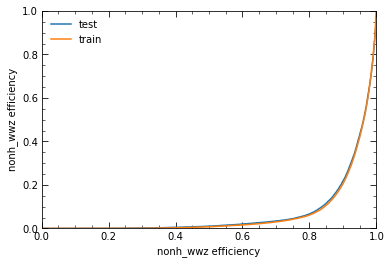

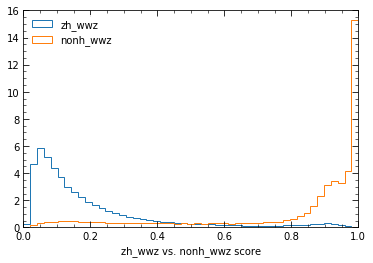

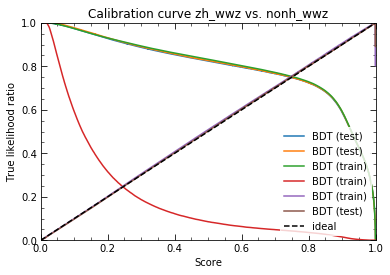

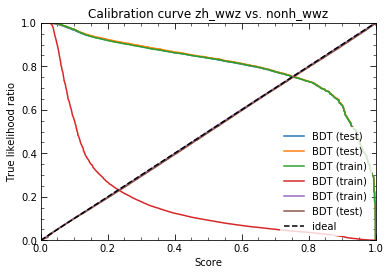

Training model zh_wwz vs ttz (neg. vs pos.)...
n_pos: 1715
n_neg: 56098
[0]	validation_0-auc:0.912472
Will train until validation_0-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.920125
[2]	validation_0-auc:0.924219
[3]	validation_0-auc:0.92757
[4]	validation_0-auc:0.929868
[5]	validation_0-auc:0.932268
[6]	validation_0-auc:0.933289
[7]	validation_0-auc:0.93437
[8]	validation_0-auc:0.934444
[9]	validation_0-auc:0.934666
[10]	validation_0-auc:0.934797
[11]	validation_0-auc:0.934897
[12]	validation_0-auc:0.93597
[13]	validation_0-auc:0.937344
[14]	validation_0-auc:0.937817
[15]	validation_0-auc:0.938169
[16]	validation_0-auc:0.938449
[17]	validation_0-auc:0.93876
[18]	validation_0-auc:0.93869
[19]	validation_0-auc:0.939006
[20]	validation_0-auc:0.939934
[21]	validation_0-auc:0.940067
[22]	validation_0-auc:0.940802
[23]	validation_0-auc:0.941233
[24]	validation_0-auc:0.941293
[25]	validation_0-auc:0.941248
[26]	validation_0-auc:0.94149
[27]	validation_0-auc:0.941756
[28]	validat

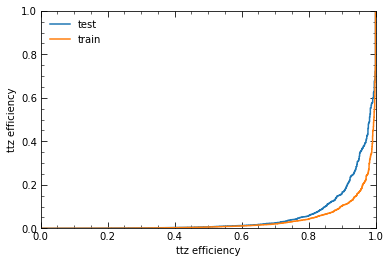

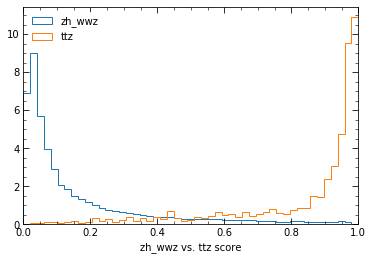

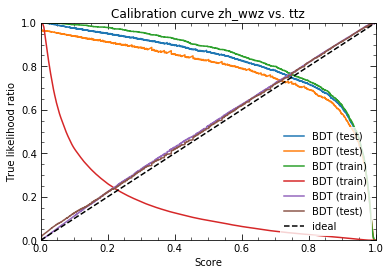

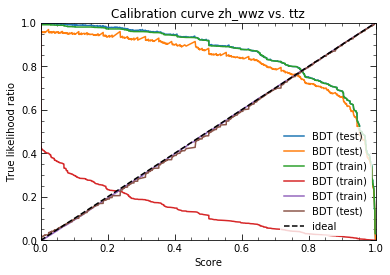

Training model zz vs nonh_wwz (neg. vs pos.)...
n_pos: 245886
n_neg: 18406
[0]	validation_0-auc:0.929676
Will train until validation_0-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.931332
[2]	validation_0-auc:0.941419
[3]	validation_0-auc:0.942931
[4]	validation_0-auc:0.943851
[5]	validation_0-auc:0.945238
[6]	validation_0-auc:0.945887
[7]	validation_0-auc:0.947463
[8]	validation_0-auc:0.947533
[9]	validation_0-auc:0.947869
[10]	validation_0-auc:0.94932
[11]	validation_0-auc:0.950159
[12]	validation_0-auc:0.950557
[13]	validation_0-auc:0.951247
[14]	validation_0-auc:0.951595
[15]	validation_0-auc:0.951947
[16]	validation_0-auc:0.952254
[17]	validation_0-auc:0.952909
[18]	validation_0-auc:0.953188
[19]	validation_0-auc:0.953432
[20]	validation_0-auc:0.95385
[21]	validation_0-auc:0.954049
[22]	validation_0-auc:0.954223
[23]	validation_0-auc:0.954493
[24]	validation_0-auc:0.954876
[25]	validation_0-auc:0.955127
[26]	validation_0-auc:0.955324
[27]	validation_0-auc:0.955558
[28]	

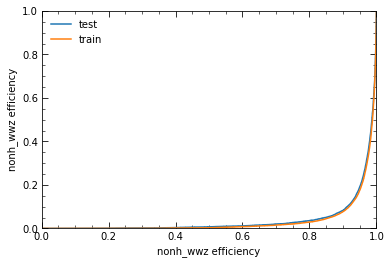

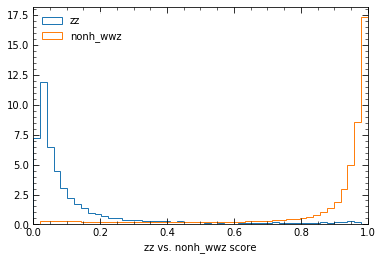

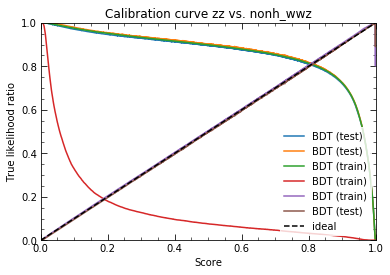

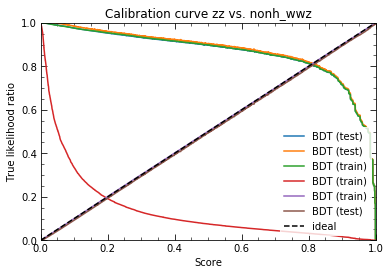

Training model zz vs ttz (neg. vs pos.)...
n_pos: 1715
n_neg: 18406
[0]	validation_0-auc:0.933819
Will train until validation_0-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.944829
[2]	validation_0-auc:0.949486
[3]	validation_0-auc:0.953719
[4]	validation_0-auc:0.956261
[5]	validation_0-auc:0.957185
[6]	validation_0-auc:0.958274
[7]	validation_0-auc:0.960336
[8]	validation_0-auc:0.961031
[9]	validation_0-auc:0.961601
[10]	validation_0-auc:0.962383
[11]	validation_0-auc:0.962726
[12]	validation_0-auc:0.964931
[13]	validation_0-auc:0.965253
[14]	validation_0-auc:0.966556
[15]	validation_0-auc:0.967089
[16]	validation_0-auc:0.967284
[17]	validation_0-auc:0.967631
[18]	validation_0-auc:0.968013
[19]	validation_0-auc:0.968279
[20]	validation_0-auc:0.968539
[21]	validation_0-auc:0.969106
[22]	validation_0-auc:0.96946
[23]	validation_0-auc:0.969649
[24]	validation_0-auc:0.969804
[25]	validation_0-auc:0.970144
[26]	validation_0-auc:0.970188
[27]	validation_0-auc:0.970377
[28]	valida

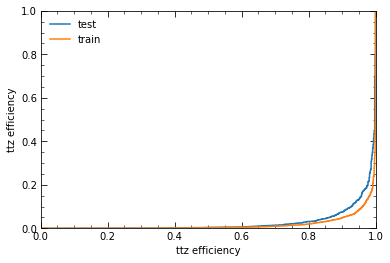

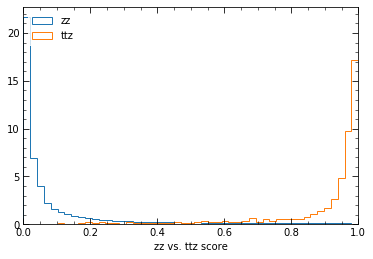

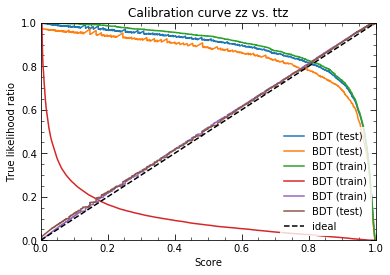

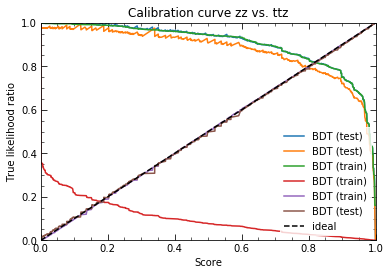

Training model zz vs zh_wwz (neg. vs pos.)...
n_pos: 56098
n_neg: 18406
[0]	validation_0-auc:0.869725
Will train until validation_0-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.874371
[2]	validation_0-auc:0.880462
[3]	validation_0-auc:0.884199
[4]	validation_0-auc:0.885112
[5]	validation_0-auc:0.887478
[6]	validation_0-auc:0.891585
[7]	validation_0-auc:0.892463
[8]	validation_0-auc:0.893126
[9]	validation_0-auc:0.893656
[10]	validation_0-auc:0.89408
[11]	validation_0-auc:0.894777
[12]	validation_0-auc:0.895467
[13]	validation_0-auc:0.896479
[14]	validation_0-auc:0.897165
[15]	validation_0-auc:0.897693
[16]	validation_0-auc:0.898162
[17]	validation_0-auc:0.898423
[18]	validation_0-auc:0.898955
[19]	validation_0-auc:0.899133
[20]	validation_0-auc:0.899607
[21]	validation_0-auc:0.899837
[22]	validation_0-auc:0.90056
[23]	validation_0-auc:0.900807
[24]	validation_0-auc:0.901266
[25]	validation_0-auc:0.901549
[26]	validation_0-auc:0.901926
[27]	validation_0-auc:0.90281
[28]	vali

[256]	validation_0-auc:0.918862
[257]	validation_0-auc:0.918871
[258]	validation_0-auc:0.918955
[259]	validation_0-auc:0.918991
[260]	validation_0-auc:0.919
[261]	validation_0-auc:0.919024
[262]	validation_0-auc:0.919056
[263]	validation_0-auc:0.91906
[264]	validation_0-auc:0.919065
[265]	validation_0-auc:0.919081
[266]	validation_0-auc:0.919084
[267]	validation_0-auc:0.919117
[268]	validation_0-auc:0.919165
[269]	validation_0-auc:0.919158
[270]	validation_0-auc:0.919164
[271]	validation_0-auc:0.919192
[272]	validation_0-auc:0.919189
[273]	validation_0-auc:0.919242
[274]	validation_0-auc:0.919284
[275]	validation_0-auc:0.919299
[276]	validation_0-auc:0.919342
[277]	validation_0-auc:0.919377
[278]	validation_0-auc:0.919379
[279]	validation_0-auc:0.919388
[280]	validation_0-auc:0.919388
[281]	validation_0-auc:0.91942
[282]	validation_0-auc:0.919424
[283]	validation_0-auc:0.919424
[284]	validation_0-auc:0.919409
[285]	validation_0-auc:0.919424
[286]	validation_0-auc:0.91944
[287]	validati

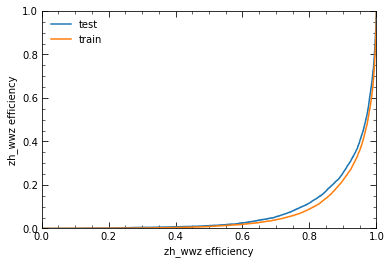

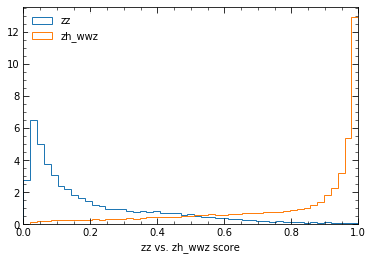

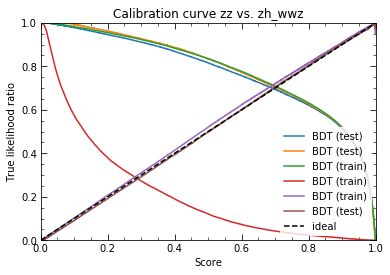

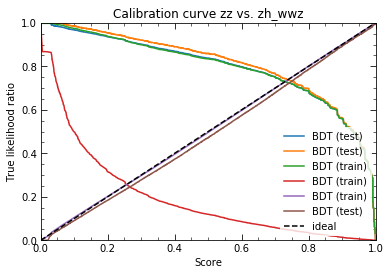

In [257]:
models = [[None] * n_classes for i in range(n_classes)]
isotonic_regressions = [[None] * n_classes for i in range(n_classes)]


for i in range(n_classes):
    for j in range(n_classes):
        if i <= j:
            continue
        print(f"Training model {index_to_label(i)} vs {index_to_label(j)} (neg. vs pos.)...")
        
        X_train_withbtag, y_train_withbtag = get_binary_data(df_train_withbtag, i, j)
        
        X_train, y_train = get_binary_data(df_train, i, j)
        X_test, y_test = get_binary_data(df_test, i, j)
        
        xgb_params_current = {**xgb_params}
        #if index_to_label(i) == "ttz" and index_to_label(j) == "nonh_wwz":
        #    xgb_params_current["max_depth"] = 2
        #    xgb_params_current["n_estimators"] = 100
        model = train_bdt(X_train_withbtag, y_train_withbtag, X_test, y_test, xgb_params_current)
        
        preds_train = model.predict_proba(X_train)[:,1]
        preds_test = model.predict_proba(X_test)[:,1]
        
        roc_xmin = 0.0
        
        plt.figure()
        fpr, tpr, _ = roc_curve(y_test, preds_test)
        plt.plot(tpr[tpr > roc_xmin], fpr[tpr > roc_xmin], label="test")
        fpr, tpr, _ = roc_curve(y_train, preds_train)
        plt.plot(tpr[tpr > roc_xmin], fpr[tpr > roc_xmin], label="train")
        plt.ylim(0, 1)
        plt.xlim(0, 1)
        plt.xlabel(index_to_label(j) + " efficiency")
        plt.ylabel(index_to_label(j) + " efficiency")
        plt.legend(loc="upper left")
        name = f"{index_to_label(i)}_vs_{index_to_label(j)}"
        plt.savefig("plots/multiclassification/roc/"+name+".pdf")
        plt.savefig("plots/multiclassification/roc/"+name+".png", dpi=300)
        plt.show()
        plt.close()
        
        bins = np.linspace(0, 1, 50)
        bin_centers = (bins[1:] + bins[:-1]) / 2.
        
        bins_for_fit = np.linspace(0, 1, 50)
        bin_centers_for_fit = (bins_for_fit[1:] + bins_for_fit[:-1]) / 2.
        
        def get_l_ratio(preds, y, bins):
            bin_centers = (bins[1:] + bins[:-1]) / 2.
            #h = np.histogram(preds, bins, density=True)[0]
            h_pos = np.histogram(preds[y == 1], bins, density=True)[0]
            h_neg = np.histogram(preds[y == 0], bins, density=True)[0]
            l_ratio = h_pos/(h_pos+h_neg)
            l_ratio[np.logical_and(np.isnan(l_ratio), bin_centers < 0.5)] = 0.0
            l_ratio[np.logical_and(np.isnan(l_ratio), bin_centers >= 0.5)] = 1.0
            
            return l_ratio
        
        l_ratio_train = get_l_ratio(preds_train, y_train, bins)
        l_ratio_test = get_l_ratio(preds_test, y_test, bins)
            
        plt.figure()
        plt.hist(preds_train[y_train == 0], bins, histtype='step', density=True, label=index_to_label(i))
        plt.hist(preds_train[y_train == 1], bins, histtype='step', density=True, label=index_to_label(j))
        plt.xlim(0, 1)
        plt.xlabel(f"{index_to_label(i)} vs. {index_to_label(j)} score")
        plt.legend(loc="upper left")
        plt.savefig("plots/multiclassification/scores/"+name+".pdf")
        plt.savefig("plots/multiclassification/scores/"+name+".png", dpi=300)
        plt.show()
        plt.close()

        #plt.figure()
        #plt.hist(preds_calib_train[y_train == 0], bins, histtype='step', density=True)
        #plt.hist(preds_calib_train[y_train == 1], bins, histtype='step', density=True)
        #plt.xlim(0, 1)
        #plt.show()
        
        regressions = []
        
        n_reg = 15
        for i_reg in range(n_reg):
            plt.figure()
            plt.title(f"Calibration curve {index_to_label(i)} vs. {index_to_label(j)}")
            p = regressions[0].transform(preds_train) if regressions else preds_train
            fpr, tpr, th = roc_curve(y_train, p)
            th_calib, y_calib = calibration_curve(y_train, p)
            
            p_test = regressions[0].transform(preds_test) if regressions else preds_test
            th_calib_test, y_calib_test = calibration_curve(y_test, p_test)

            plt.plot(th, tpr, label="BDT (train)")
            plt.plot(th, fpr, label="BDT (train)")

            plt.plot(th_calib, y_calib, label="BDT (train)")
            plt.plot(th_calib_test, y_calib_test, label="BDT (test)")



            regressions.append(IsotonicRegression(out_of_bounds='clip', y_min=0.0, y_max=1.0).fit(
                th_calib, y_calib
            ))
        
            if len(regressions) > 1:
                p = preds_train
                for reg in regressions:
                    p = reg.transform(p)
            regressions = [IsotonicRegression(out_of_bounds='clip', y_min=0.0, y_max=1.0).fit(
                np.concatenate([[0.0], preds_train, [1.0]]),
                np.concatenate([[0.0], p, [1.0]]),
            )   
            ]
    
            #plt.step(bins[:-1], l_ratio_test, label="BDT (test)", linewidth=1)
            #plt.step(bins[:-1], l_ratio_train, label="BDT (train)", linewidth=1)
            #plt.step(bins[:-1], l_ratio_calib_test, label="calibrated BDTs (test)")
            #plt.step(bins[:-1], l_ratio_calib_train, label="calibrated BDTs (train)")
            plt.plot([0,1], [0,1], 'k--', label="ideal")
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.xlabel("Score")
            plt.ylabel("True likelihood ratio")
            plt.legend(loc="lower right")
            if i_reg == n_reg-1 or i_reg == 0:
                plt.show()
            #plt.savefig("plots/multiclassification/calibration/"+name+".pdf")
            #plt.savefig("plots/multiclassification/calibration/"+name+".png", dpi=300)
            plt.close()
        
        '''
        def calibration_quality(calib_func):
            fpr, tpr, th = roc_curve(y_test, calib_func(preds_test))
            lhs = tpr
            sums = (fpr + tpr)[1::] * np.diff(th)
            rhs = (th*(fpr + tpr))[1:] + np.cumsum(sums[::-1])[::-1] + 1.
            
            q = np.sum((lhs[1:] - rhs)**2)
            print(q)
            return q
        
        print(calibration_quality(lambda x: x))
        
        # Polynomial calibration
        def target_func(p):
            def f(x):
                py = np.polyval(p, x)
                r = np.sum(p) - 1
                #print(r, "hi")
                out = x * (py - r)
                #print(out)
                return out
            #return f
            return calibration_quality(f)
        
        print(target_func([0.0, 0.0, 0.0, 0.0, 0.0]))
        print(target_func([0.01, 0.01, 0.01, 0.04, 0.05]))
        print(scipy.optimize.minimize(target_func, np.random.normal(size=(2,))))
        
        #x = np.linspace(0, 1, 200)
        #plt.plot(x, target_func(np.zeros(5))(x))
        #plt.show()
        #print(target_func([0.0, 1.0, 1.0]))
        '''

        models[j][i] = model
        assert(len(regressions) == 1)
        isotonic_regressions[j][i] = regressions[0]

In [258]:
def get_likelihood_ratios(df, models):
    n_classes = len(models)
    r = np.zeros((df.shape[0], n_classes, n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            if i <= j:
                continue

            model = models[j][i]

            r[:,j,i] = model.predict_proba(df[features].values)[:,1]
            #r[:,j,i] = isotonic_regressions[j][i].transform(r[:,j,i])
            r[:,i,j] = 1-r[:,j,i]

    r = (1-r) / r
    r[np.isnan(r)] = 1.0
    r[np.isinf(r)] = 1.0
    
    return r

Actually, we don't need to further calibrate the BDTs.

In [259]:
ratio_test = get_likelihood_ratios(df_test, models)

<ipython-input-258-0e57eef162f7>:16: RuntimeWarning: divide by zero encountered in true_divide
  r = (1-r) / r


## Calibrate the Likelihood Ratios

In [260]:
df_emu = df.query("is_ChannelEMu")

In [261]:
yields = df_emu.groupby("sample_index")["weight"].sum()
assert((np.diff(yields.index.values) > 0).all())
yields = yields.values

In [262]:
yields

array([ 8.13110989,  3.9651825 ,  6.53546018, 17.56869573])

In [263]:
def get_final_likelihood_ratio(r, zh_as_background=False, nonh_as_background=False):
    w_1 = yields / np.sum(yields)
    w_0 = np.copy(w_1)
    
    if not nonh_as_background:
        w_0[0] = 1e-10
    if not zh_as_background:
        w_0[2] = 1e-10
    w_0 /= np.sum(w_0)

    w_r = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            w_r[i, j] = w_1[j] / w_0[i]

    inner_sum = 1.0 / np.sum(w_r * r, axis=-1)

    l_ratios = np.sum(inner_sum, axis=-1)

    return l_ratios
    return np.log(l_ratios)

In [264]:
data = load_dataframes(skims.keys(), exclude_training=False)

In [265]:
import pandas as pd

In [266]:
for key in data:
    print(key)
    r = get_likelihood_ratios(data[key], models)
    data[key]["EMu_score"] = 1./get_final_likelihood_ratio(r, zh_as_background=False)
    data[key]["EMu_score_nonh"] = 1./get_final_likelihood_ratio(r, zh_as_background=True)
    data[key]["EMu_score_vh"] = 1./get_final_likelihood_ratio(r, zh_as_background=False, nonh_as_background=True)
    
    df_score = pd.DataFrame(
        {
            "EMu_score": data[key]["EMu_score"],
            "EMu_score_nonh": data[key]["EMu_score_nonh"],
            "EMu_score_vh": data[key]["EMu_score_vh"],
        }
    )

    df_score.to_hdf("bdt_scores/" + key + "_multiclassification.hdf", key="bdt_scores")

ttbar
higgs
zh_wwz


<ipython-input-258-0e57eef162f7>:16: RuntimeWarning: divide by zero encountered in true_divide
  r = (1-r) / r


nonh_wzz
nonh_zzz
twz
rare
zh_zzz
zz
dy
wz
nonh_wwz
wh_wzz
data
ttz
